<a href="https://colab.research.google.com/github/karagulruhi/-dev2/blob/main/STYLEGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import InceptionV3

import os
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.utils import to_categorical
from PIL import Image
from keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import tensorflow as tf
import tensorflow

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.layers.experimental import RandomFourierFeatures

In [ ]:
if not os.path.exists('/content/Alzheimer_sDataset'):
  !unrar x /content/Alzheimer_sDataset.rar
else:
  print('Archive already exists. Skipping download.')


In [ ]:
if not os.path.exists('/content/kritik'):
  !unrar x /content/kritik.rar
else:
  print('Archive already exists. Skipping download.')

In [ ]:
img_width=224
img_height=224
BATCH_SIZE=32
EPOCHS=100
SEED= 1564


In [ ]:
train_path='/content/Alzheimer_s Dataset/train'
test_path='/content/Alzheimer_s Dataset/test'

In [ ]:
train_amount = {
    'MildDemented': len(glob(train_path + '/MildDemented/*.jpg')),
    'ModerateDemented': len(glob(train_path + '/ModerateDemented/*.jpg')),
    'VeryMildDemented': len(glob(train_path + '/VeryMildDemented/*.jpg')),
    'Healthy': len(glob(train_path + '/NonDemented/*.jpg'))
}
test_amount = {
    'MildDemented': len(glob(test_path + '/MildDemented/*.jpg')),
    'ModerateDemented': len(glob(test_path + '/ModerateDemented/*.jpg')),
    'VeryMildDemented': len(glob(test_path + '/VeryMildDemented/*.jpg')),
    'Healthy': len(glob(test_path + '/NonDemented/*.jpg'))

}
total_train_count = sum(train_amount.values())
total_test_count = sum(test_amount.values())

print(train_amount)
print(test_amount)

{'MildDemented': 717, 'ModerateDemented': 52, 'VeryMildDemented': 1792, 'Healthy': 2560}
{'MildDemented': 179, 'ModerateDemented': 12, 'VeryMildDemented': 448, 'Healthy': 640}


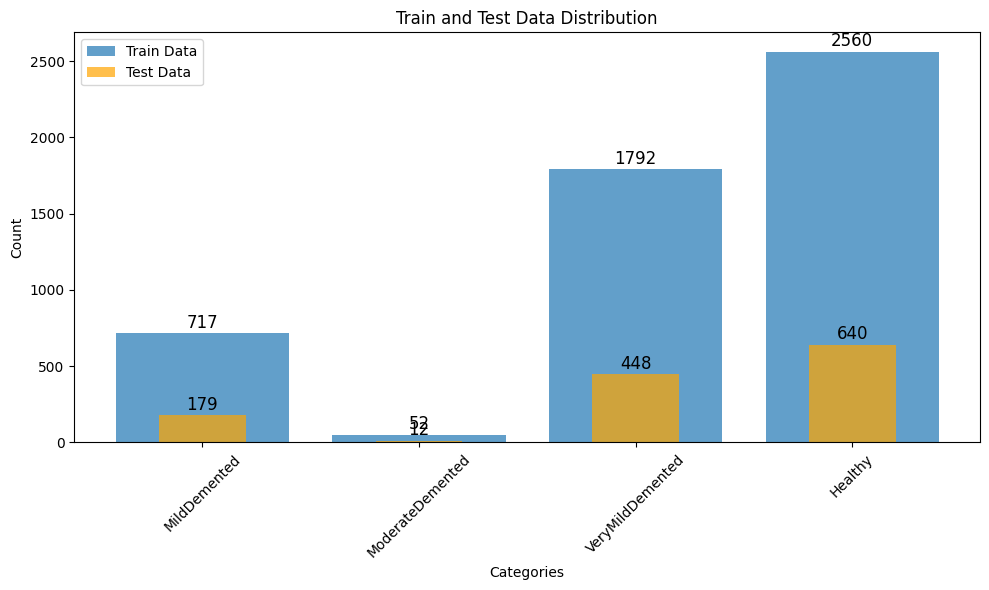

In [ ]:

categories = ['MildDemented', 'ModerateDemented', 'VeryMildDemented', 'Healthy']
train_counts = [train_amount[category] for category in categories]
test_counts = [test_amount[category] for category in categories]


plt.figure(figsize=(10, 6))
plt.bar(categories, train_counts, label='Train Data', alpha=0.7)
plt.bar(categories, test_counts, label='Test Data', alpha=0.7, color='orange', width=0.4)

for i, count in enumerate(train_counts):
    plt.text(i, count + 10, str(count), ha='center', va='bottom', fontsize=12)

for i, count in enumerate(test_counts):
    plt.text(i, count + 10, str(count), ha='center', va='bottom', fontsize=12)


plt.title('Train and Test Data Distribution')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:


total_train_count = sum(train_amount.values())
total_test_count = sum(test_amount.values())


train_percentages = {category: count / total_train_count * 100 for category, count in train_amount.items()}
test_percentages = {category: count / total_test_count * 100 for category, count in test_amount.items()}


print("Train data percentages:")
for category, percentage in train_percentages.items():
    print(f"{category}: {percentage:.2f}%")

print("\nTest data percentages:")
for category, percentage in test_percentages.items():
    print(f"{category}: {percentage:.2f}%")


Train data percentages:
MildDemented: 14.00%
ModerateDemented: 1.02%
VeryMildDemented: 34.99%
Healthy: 49.99%

Test data percentages:
MildDemented: 14.00%
ModerateDemented: 0.94%
VeryMildDemented: 35.03%
Healthy: 50.04%


Found 5121 files belonging to 4 classes.
['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


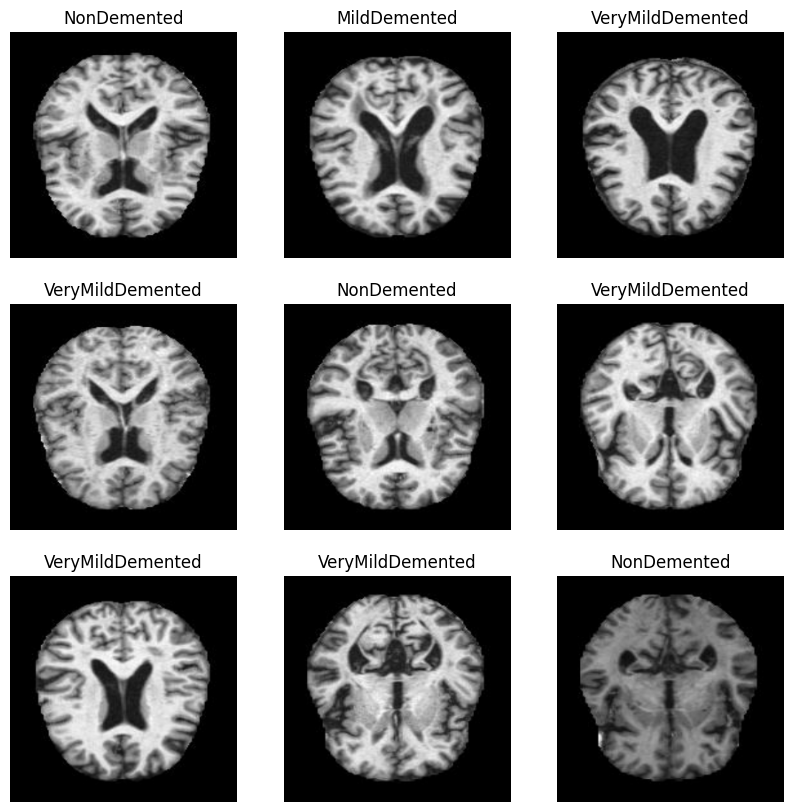

In [ ]:
invest=tf.keras.utils.image_dataset_from_directory(train_path)
class_names = invest.class_names
print(class_names)
plt.figure(figsize=(10, 10))
for images, labels in invest.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
img_width=224
img_height=224
BATCH_SIZE=32
EPOCHS=50
SEED= 1564

In [ ]:

train_gen = ImageDataGenerator( validation_split=0,
                                rescale = 1./255,
                                brightness_range=[0.8, 1.2],
                                zoom_range=[.99, 1.01],
                                fill_mode="constant",
                                horizontal_flip=True
                              )
train_data = train_gen.flow_from_directory(
                                directory=train_path,
                                class_mode='categorical',
                                shuffle =True,
                                subset='training',
                                batch_size=BATCH_SIZE,
                                seed=SEED,
                                target_size=(img_height, img_width)
                        )

ts_gen = ImageDataGenerator(rescale=1.0 / 255)
test_data = ts_gen.flow_from_directory(
                                directory=test_path,
                                class_mode='categorical',
                                batch_size=BATCH_SIZE,
                                shuffle=False,
                                seed= SEED,
                                target_size=(img_height, img_width)
                        )


image_generator_submission = ImageDataGenerator(rescale=1/255,validation_split=0.2)
valid_data =image_generator_submission.flow_from_directory(
                                directory=train_path,
                                class_mode='categorical',
                                subset='validation',
                                seed = SEED,
                                shuffle=False,
                                batch_size=BATCH_SIZE,
                                target_size=(img_height, img_width)
                        )

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.


In [ ]:
vgg_model = VGG16(input_shape=(img_height, img_width,3),
                   include_top=False,
                   weights="imagenet")

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in vgg_model.layers:
    layer.trainable=False

In [ ]:

model = Sequential()
model.add(vgg_model)
model.add(Dropout(rate=0.5))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(BatchNormalization())
model.add(Dense(4, activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                        

In [ ]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('auc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True

my_callback = MyCallback()

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)
callback= [my_callback,rop_callback]

In [ ]:
from tensorflow.keras.optimizers import Adam


metric = [tensorflow.keras.metrics.AUC(name='auc')]
model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=metric)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

hist = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=EPOCHS,
    verbose = 1,
    callbacks=callback
)

Epoch 1/50
161/161 [==============================] - 84s 447ms/step - loss: 1.3431 - auc: 0.7506 - val_loss: 0.7882 - val_auc: 0.9131 - lr: 0.0010
Epoch 2/50
161/161 [==============================] - 66s 408ms/step - loss: 0.9716 - auc: 0.8464 - val_loss: 0.9683 - val_auc: 0.8699 - lr: 0.0010
Epoch 3/50
161/161 [==============================] - 66s 408ms/step - loss: 0.8827 - auc: 0.8653 - val_loss: 0.7402 - val_auc: 0.9150 - lr: 0.0010
Epoch 4/50
161/161 [==============================] - 65s 405ms/step - loss: 0.8118 - auc: 0.8819 - val_loss: 0.7319 - val_auc: 0.9066 - lr: 0.0010
Epoch 5/50
161/161 [==============================] - 66s 412ms/step - loss: 0.7679 - auc: 0.8926 - val_loss: 0.5057 - val_auc: 0.9592 - lr: 0.0010
Epoch 6/50
161/161 [==============================] - 65s 405ms/step - loss: 0.7149 - auc: 0.9072 - val_loss: 0.5509 - val_auc: 0.9453 - lr: 0.0010
Epoch 7/50
161/161 [==============================] - 66s 407ms/step - loss: 0.6938 - auc: 0.9124 - val_loss: 0.

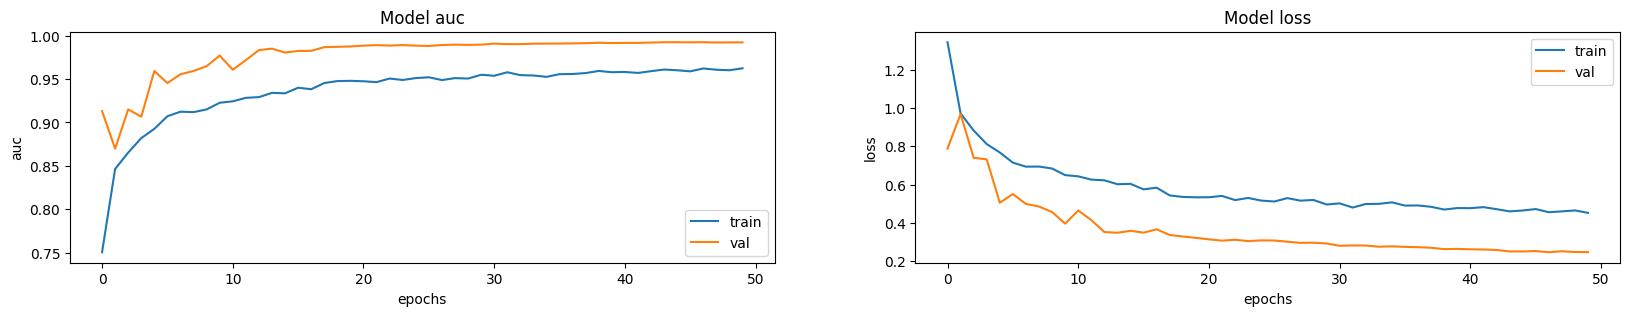

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

40/40 [==============================] - 5s 123ms/step


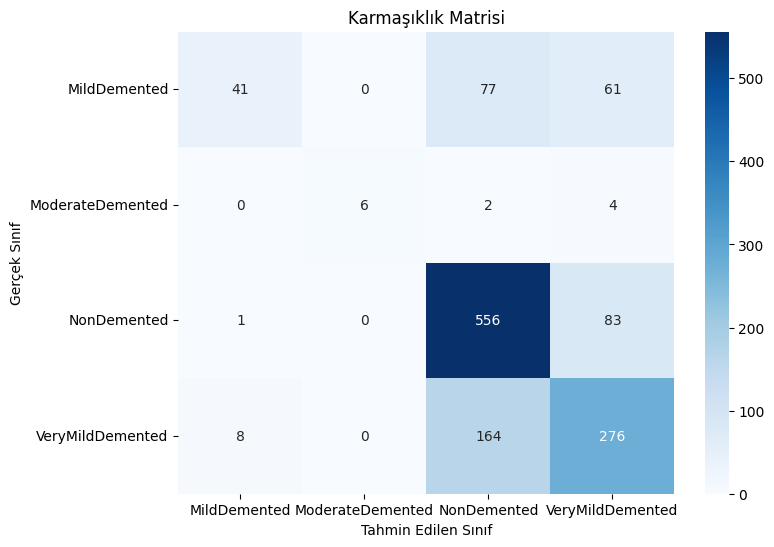

Sınıf bazında Doğruluk Raporu:
                   precision    recall  f1-score   support

    MildDemented       0.82      0.23      0.36       179
ModerateDemented       1.00      0.50      0.67        12
     NonDemented       0.70      0.87      0.77       640
VeryMildDemented       0.65      0.62      0.63       448

        accuracy                           0.69      1279
       macro avg       0.79      0.55      0.61      1279
    weighted avg       0.70      0.69      0.66      1279

Genel Doğruluk: 0.6872556684910086


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

y_pred = model.predict(test_data)

y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_data.classes

class_labels = list(test_data.class_indices.keys())

# Karmaşıklık matrisini hesaplayın
cm = confusion_matrix(y_true, y_pred_classes)


accuracy = accuracy_score(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.title("Karmaşıklık Matrisi")
plt.show()

print("Sınıf bazında Doğruluk Raporu:\n", classification_report(y_true, y_pred_classes, target_names=class_labels))

print("Genel Doğruluk:", accuracy)

**STYLEGAN İLE HAZIRLANMIŞ DATA SETİNİ EKLEME**

In [ ]:
import os
from PIL import Image
import shutil

source_folder = r"/content/styleganpazar"
destination_folder = r"ganerative_dataset"


os.makedirs(destination_folder, exist_ok=True)

moderate_demented_folder = os.path.join(source_folder, "train/ModerateDemented")
moderate_demented_destination = os.path.join(destination_folder, "train/ModerateDemented")

mild_demented_folder = os.path.join(source_folder, "train/MildDemented")
mild_demented_destination = os.path.join(destination_folder, "train/MildDemented")


os.makedirs(moderate_demented_destination, exist_ok=True)
os.makedirs(mild_demented_destination, exist_ok=True)

def copy_and_convert_images(source_folder, destination_folder):
    for item in os.listdir(source_folder):
        source_item = os.path.join(source_folder, item)
        destination_item = os.path.join(destination_folder, item)

        if os.path.isfile(source_item):
            img = Image.open(source_item).convert('L')  # 'L' modu siyah beyaz yapar
            img.save(destination_item)
        else:

            shutil.copytree(source_item, destination_item)


copy_and_convert_images(moderate_demented_folder, moderate_demented_destination)


copy_and_convert_images(mild_demented_folder, mild_demented_destination)


for root, dirs, files in os.walk(source_folder):
    for dir in dirs:
        source_dir = os.path.join(root, dir)
        dest_dir = source_dir.replace(source_folder, destination_folder)
        os.makedirs(dest_dir, exist_ok=True)

    for file in files:
        if not (root in [moderate_demented_folder, mild_demented_folder] and file.endswith('.jpg')):
            source_file = os.path.join(root, file)
            dest_file = source_file.replace(source_folder, destination_folder)
            shutil.copy2(source_file, dest_file)


In [ ]:
train_path='/content/kritik/train'
test_path='/content/kritik/test'

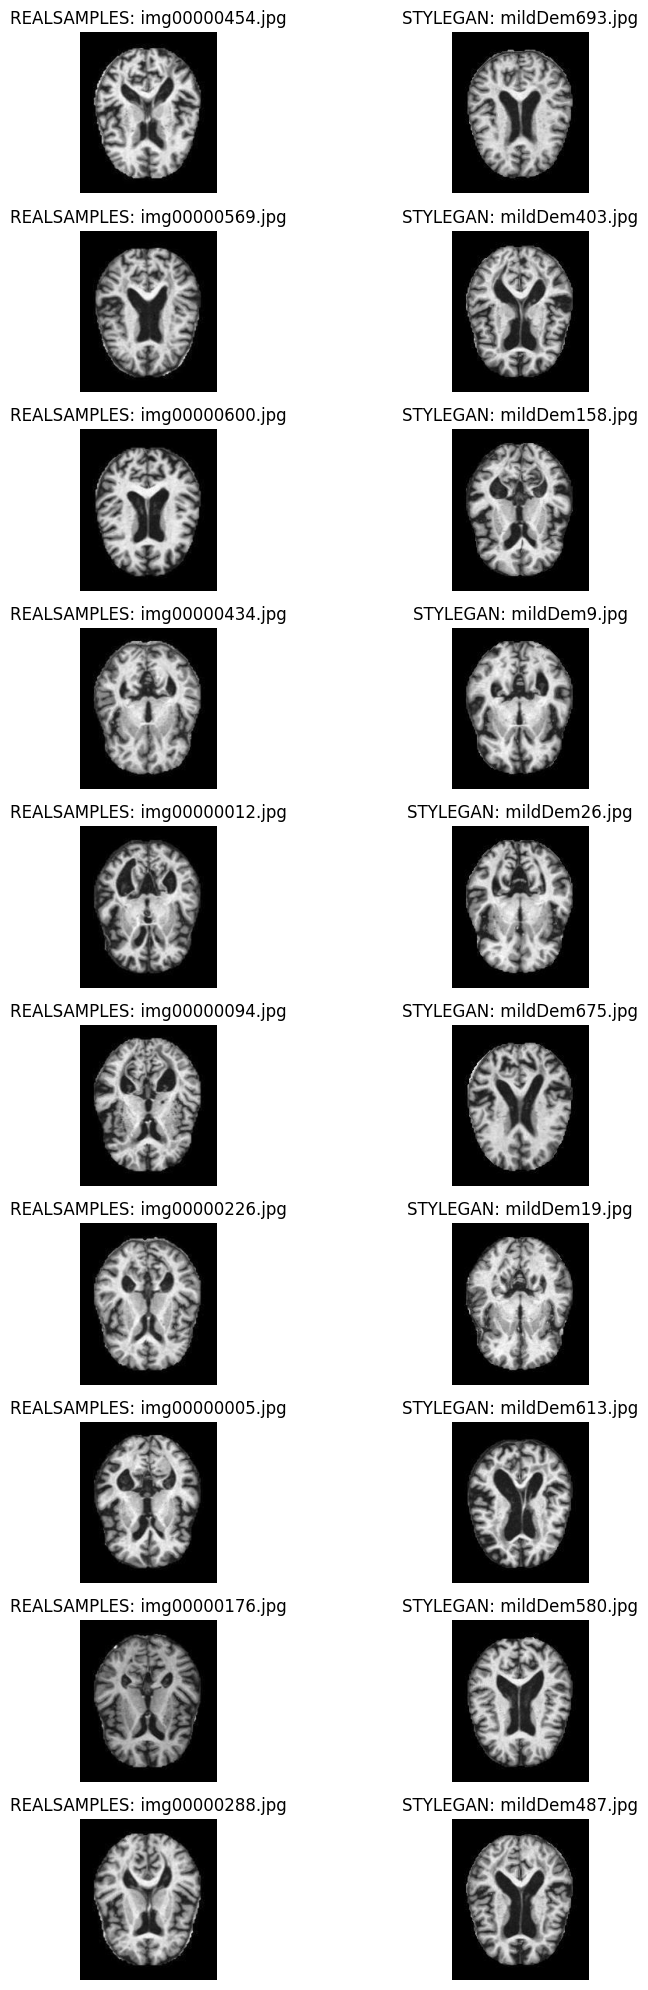

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Veri dizini
data_dir = '/content/ganerative_dataset/train/MildDemented'

# Örneklerin seçilmesi
img000_samples = random.sample([f for f in os.listdir(data_dir) if f.startswith('img000')], 10)
milddem_samples = random.sample([f for f in os.listdir(data_dir) if f.startswith('mildDem')], 10)

fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(10, 20))

for i in range(10):
    # img000 örnekleri (siyah beyaz)
    img000_path = os.path.join(data_dir, img000_samples[i])
    img000 = Image.open(img000_path).convert('L')
    axes[i, 0].imshow(img000, cmap='gray')
    axes[i, 0].set_title(f'REALSAMPLES: {img000_samples[i]}')
    axes[i, 0].axis('off')

    # milddem örnekleri (siyah beyaz)
    milddem_path = os.path.join(data_dir, milddem_samples[i])
    milddem = Image.open(milddem_path).convert('L')
    axes[i, 1].imshow(milddem, cmap='gray')
    axes[i, 1].set_title(f'STYLEGAN: {milddem_samples[i]}')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
train_amount = {
    'MildDemented': len(glob(train_path + '/MildDemented/*.jpg')),
    'ModerateDemented': len(glob(train_path + '/ModerateDemented/*.jpg')),
    'VeryMildDemented': len(glob(train_path + '/VeryMildDemented/*.jpg')),
    'Healthy': len(glob(train_path + '/NonDemented/*.jpg'))
}
test_amount = {
    'MildDemented': len(glob(test_path + '/MildDemented/*.jpg')),
    'ModerateDemented': len(glob(test_path + '/ModerateDemented/*.jpg')),
    'VeryMildDemented': len(glob(test_path + '/VeryMildDemented/*.jpg')),
    'Healthy': len(glob(test_path + '/NonDemented/*.jpg'))

}
total_train_count = sum(train_amount.values())
total_test_count = sum(test_amount.values())

print(train_amount)
print(test_amount)

{'MildDemented': 1434, 'ModerateDemented': 552, 'VeryMildDemented': 1792, 'Healthy': 2560}
{'MildDemented': 181, 'ModerateDemented': 12, 'VeryMildDemented': 448, 'Healthy': 640}


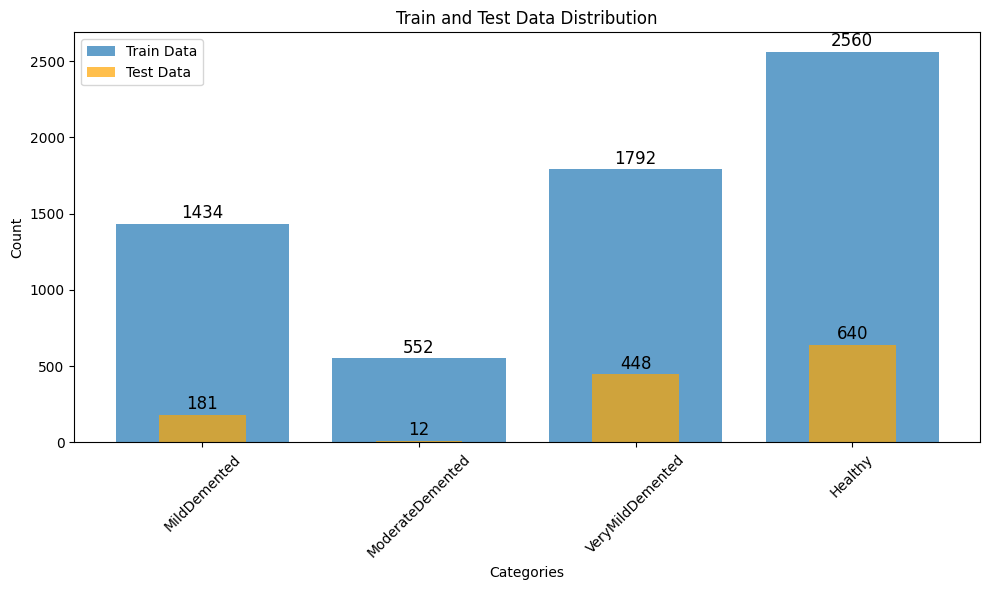

In [ ]:

categories = ['MildDemented', 'ModerateDemented', 'VeryMildDemented', 'Healthy']
train_counts = [train_amount[category] for category in categories]
test_counts = [test_amount[category] for category in categories]

plt.figure(figsize=(10, 6))
plt.bar(categories, train_counts, label='Train Data', alpha=0.7)
plt.bar(categories, test_counts, label='Test Data', alpha=0.7, color='orange', width=0.4)


for i, count in enumerate(train_counts):
    plt.text(i, count + 10, str(count), ha='center', va='bottom', fontsize=12)

for i, count in enumerate(test_counts):
    plt.text(i, count + 10, str(count), ha='center', va='bottom', fontsize=12)


plt.title('Train and Test Data Distribution')
plt.xlabel('Categories')
plt.ylabel('Count')


plt.xticks(rotation=45)
plt.legend()


plt.tight_layout()
plt.show()

In [ ]:

total_train_count = sum(train_amount.values())
total_test_count = sum(test_amount.values())


train_percentages = {category: count / total_train_count * 100 for category, count in train_amount.items()}
test_percentages = {category: count / total_test_count * 100 for category, count in test_amount.items()}

print("Train data percentages:")
for category, percentage in train_percentages.items():
    print(f"{category}: {percentage:.2f}%")

print("\nTest data percentages:")
for category, percentage in test_percentages.items():
    print(f"{category}: {percentage:.2f}%")

Train data percentages:
MildDemented: 22.63%
ModerateDemented: 8.71%
VeryMildDemented: 28.27%
Healthy: 40.39%

Test data percentages:
MildDemented: 14.13%
ModerateDemented: 0.94%
VeryMildDemented: 34.97%
Healthy: 49.96%


In [ ]:

train_gen = ImageDataGenerator( validation_split=0,
                                rescale = 1./255,
                                brightness_range=[0.8, 1.2],
                                zoom_range=[.99, 1.01],
                                fill_mode="constant",
                                horizontal_flip=True
                              )
train_data = train_gen.flow_from_directory(
                                directory=train_path,
                                class_mode='categorical',
                                shuffle =True,
                                subset='training',
                                batch_size=BATCH_SIZE,
                                seed=SEED,
                                target_size=(img_height, img_width)
                        )

ts_gen = ImageDataGenerator(rescale=1.0 / 255)
test_data = ts_gen.flow_from_directory(
                                directory=test_path,
                                class_mode='categorical',
                                batch_size=BATCH_SIZE,
                                shuffle=False,
                                seed= SEED,
                                target_size=(img_height, img_width)
                        )


image_generator_submission = ImageDataGenerator(rescale=1/255,validation_split=0.2)
valid_data =image_generator_submission.flow_from_directory(
                                directory=train_path,
                                class_mode='categorical',
                                subset='validation',
                                seed = SEED,
                                shuffle=False,
                                batch_size=BATCH_SIZE,
                                target_size=(img_height, img_width)
                        )

Found 6338 images belonging to 4 classes.
Found 1281 images belonging to 4 classes.
Found 1266 images belonging to 4 classes.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

hist = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=EPOCHS,
    verbose = 1,
    callbacks=callback
)

Epoch 1/50
199/199 [==============================] - 87s 436ms/step - loss: 0.5868 - auc: 0.9424 - val_loss: 0.2796 - val_auc: 0.9885 - lr: 1.0000e-05
Epoch 2/50
199/199 [==============================] - 81s 407ms/step - loss: 0.5604 - auc: 0.9467 - val_loss: 0.2632 - val_auc: 0.9904 - lr: 1.0000e-05
Epoch 3/50
199/199 [==============================] - 82s 412ms/step - loss: 0.5080 - auc: 0.9543 - val_loss: 0.2530 - val_auc: 0.9916 - lr: 1.0000e-05
Epoch 4/50
199/199 [==============================] - 82s 413ms/step - loss: 0.5106 - auc: 0.9538 - val_loss: 0.2420 - val_auc: 0.9927 - lr: 1.0000e-05
Epoch 5/50
199/199 [==============================] - 82s 410ms/step - loss: 0.4999 - auc: 0.9554 - val_loss: 0.2324 - val_auc: 0.9936 - lr: 1.0000e-05
Epoch 6/50
199/199 [==============================] - 81s 409ms/step - loss: 0.4746 - auc: 0.9597 - val_loss: 0.2293 - val_auc: 0.9938 - lr: 1.0000e-05
Epoch 7/50
199/199 [==============================] - 82s 413ms/step - loss: 0.4839 - au

41/41 [==============================] - 5s 122ms/step


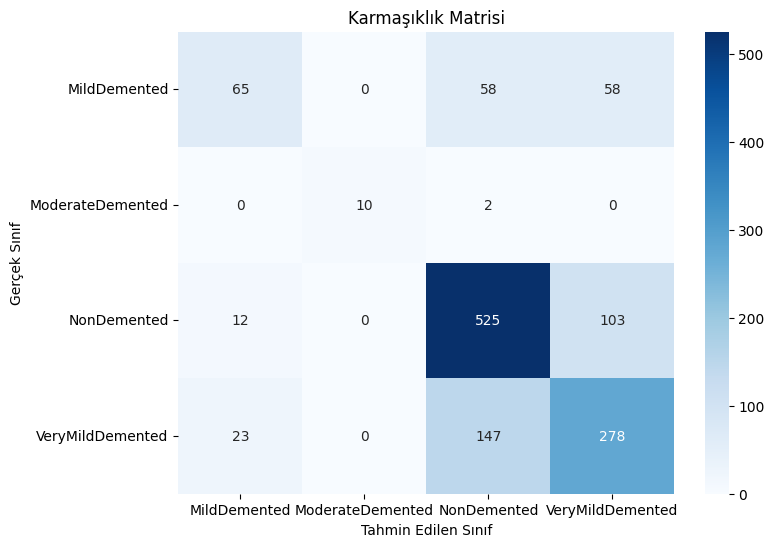

Sınıf bazında Doğruluk Raporu:
                   precision    recall  f1-score   support

    MildDemented       0.65      0.36      0.46       181
ModerateDemented       1.00      0.83      0.91        12
     NonDemented       0.72      0.82      0.77       640
VeryMildDemented       0.63      0.62      0.63       448

        accuracy                           0.69      1281
       macro avg       0.75      0.66      0.69      1281
    weighted avg       0.68      0.69      0.68      1281

Genel Doğruluk: 0.6854020296643247


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

y_pred = model.predict(test_data)

y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_data.classes

class_labels = list(test_data.class_indices.keys())

# Karmaşıklık matrisini hesaplayın
cm = confusion_matrix(y_true, y_pred_classes)


accuracy = accuracy_score(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.title("Karmaşıklık Matrisi")
plt.show()

print("Sınıf bazında Doğruluk Raporu:\n", classification_report(y_true, y_pred_classes, target_names=class_labels))

print("Genel Doğruluk:", accuracy)

In [ ]:


# Save the output
!jupyter nbconvert --to html "Alzheimer_s_Dataset_VGG16_Stylegan.ipynb"

# Shutdown the TPU
!tpu-shutdown
